## Churn prediction - Kaggle competition

- Even when a Kaggle competition is over we can still download the data, read notebooks of participants and learn!
<br>And then submit our own prediction to see how well our model perform. 

##### This a an exploratory analysis and prediction with XGBoost for Kaggle competition:

["WSDM - KKBox's Churn Prediction Challenge
Can you predict when subscribers will churn?"](https://www.kaggle.com/c/kkbox-churn-prediction-challenge/)


**Churn definition (in data description on Kaggle)** 
>The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.

In [1]:
import random
import pandas as pd
import xgboost as xgb
from os.path import join

import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

## Loading the data

The files set provided contains bigger files with data till the end of February 2017 and additional files ("v2" suffix) with update of March 2017.
<br>They are too big to load them all into python but we can concatenate some of them in GNU terminal (Git Bash):
><code>cat transactions.csv > transactions_v3.csv; tail -n +2 transactions_v2.csv >> transactions_v3.csv </code>

In [2]:
PROJECT_DIR = r"C:\Users\Olks\Desktop\churn_prediction"

In [3]:
train_path = join(PROJECT_DIR, "train.csv")
train_v2_path = join(PROJECT_DIR, "train_v2.csv")
user_logs_path = join(PROJECT_DIR, "user_logs.csv")
user_logs_v2_path = join(PROJECT_DIR, "user_logs_v2.csv")
sample_submission_zero_path = join(PROJECT_DIR, "sample_submission_zero.csv")
sample_submission_v2_path = join(PROJECT_DIR, "sample_submission_v2.csv")
transactions_path = join(PROJECT_DIR, "transactions.csv")
transactions_v2_path = join(PROJECT_DIR, "transactions_v2.csv")
transactions_v3_path = join(PROJECT_DIR, "transactions_v3.csv")
members_v3_path = join(PROJECT_DIR, "members_v3.csv")

#### Some files are to big to load them so we will use spark to query them

In [2]:
from pyspark import SparkContext
sc = SparkContext("local", "First App")
print(sc)
print(sc.version)

In [5]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Create my_spark
# getOrCreate() returns an existing if there is one already
my_spark = SparkSession.builder.getOrCreate()

# Print my_spark
print(my_spark)

print(my_spark.catalog.listTables())

In [ ]:
file_path = user_logs_path

# Read in the airports data
user_logs = my_spark.read.csv(file_path, header=True)

# Show the data
user_logs.show()

In [16]:
from pyspark.sql import functions as f

In [ ]:
user_logs.select("date").show()

In [18]:
user_logs.createOrReplaceTempView("user_logs")

In [18]:
# max_date = my_spark.sql("SELECT MAX(date) FROM user_logs")
# max_date.show()

Maximum date in user_logs file: 20170228

In [ ]:
# start: 22:38
# java.lang.OutOfMemoryError
# query = "SELECT msno, MAX(date) FROM user_logs GROUP BY msno"
# last_log = my_spark.sql(query)
# last_log_df = last_log.toPandas()
# last_log_df.to_csv("last_log.csv")
# last_log_df

In [ ]:
# filter only logs from february and save them to csv
query = "SELECT* FROM user_logs WHERE date >= 20170201"
february = my_spark.sql(query)
# df=february.toPandas()
february.show()
february.coalesce(1).write.format('csv').save("february_logs.csv", header='true')

In [ ]:
my_spark.stop()

### Exploration of the data

#### First data check: reading 1000 lines per file because they are too big read them all at once
- Later we can read selected columns or whole files by chunks

In [4]:
train = pd.read_csv(train_path, nrows=1000)
train_v2 = pd.read_csv(train_v2_path, nrows=1000)
user_logs = pd.read_csv(user_logs_path, nrows=1000) 
user_logs_v2 = pd.read_csv(user_logs_v2_path, nrows=1000)
sample_submission_zero = pd.read_csv(sample_submission_zero_path, nrows=1000)
sample_submission_v2 = pd.read_csv(sample_submission_v2_path, nrows=1000)
transactions = pd.read_csv(transactions_path, nrows=1000)
transactions_v2 = pd.read_csv(transactions_v2_path, nrows=1000)
transactions_v3 = pd.read_csv(transactions_v3_path, nrows=1000) 
members_v3 = pd.read_csv(members_v3_path, nrows=1000)

In [5]:
tables = {
    "train": train, 
    "train_v2": train_v2, 
    "user_logs": user_logs,
    "user_logs_v2": user_logs_v2, 
    "sample_submission_zero": sample_submission_zero, 
    "sample_submission_v2": sample_submission_v2,
    "transactions": transactions,
    "transactions_v2": transactions_v2,
    "transactions_v3": transactions_v3,
    "members_v3": members_v3
}

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
for table_name, table in tables.items():
    print("\n------------------------------------------------------")
    print(f"Table name: \"{table_name}\"")
    display(table.describe().transpose())
    display(table.dtypes.transpose())

### Basic Trasactional Features

The challenge winner, Bryian Gregory, gives a few tips in his article, <br>
**"Predicting Customer Churn: Extreme Gradient Boosting with Temporal Data"**
<br>
https://medium.com/@bryan.gregory1/predicting-customer-churn-extreme-gradient-boosting-with-temporal-data-332c0d9f32bf

He gives a hint that the features should be relative to a cutoff day. He calls it "Relative Refactoring Method".
<br> So we should transform the day of first transaction into the number of days from the first transaction.
<br> Only if days are "special" like holidays we could live them as exact days. We should not mix those approaches.
<br> Here, only relative features will be calaculated.

1. **days_from_start** = Number of days from first transaction
2. **transactions_num** = Number or transactions
3. **cancelations_num** = Number of cancelations
4. **last_is_auto_renew** = If last subscription is renewed automatically
5. **subscription_length** = Length of last subscription

Now we need to load whole files or columns.
To create our first 3 features we need 4 columns from "transactions" files:
<br>
"msno", "transaction_date", "membership_expire_date", "is_cancel".
<br> UPDATE: Tocalculate 5 features we need 5 columns (same as previously plus "is_auto_renew")

In [4]:
columns_needed = ["msno", "transaction_date", "membership_expire_date", "is_cancel", "is_auto_renew"]

transactions = pd.read_csv(transactions_path, usecols=columns_needed)
transactions_v2 = pd.read_csv(transactions_v2_path, usecols=columns_needed)
transactions_v3 = pd.read_csv(transactions_v3_path, usecols=columns_needed)

In [5]:
# labels provided
train_v2 = pd.read_csv(train_v2_path)
train = pd.read_csv(train_path)

# test set for Kaggle submission
sample_submission_v2 = pd.read_csv(sample_submission_v2_path)

In [6]:
def calculate_last_subsciption_features(transactions_table):
    
    # change date format from int to pandas datetime
    transactions_table["transaction_date"] = pd.to_datetime(transactions_table["transaction_date"], format='%Y%m%d')
    transactions_table["membership_expire_date"] = pd.to_datetime(transactions_table["membership_expire_date"], format='%Y%m%d')
    
    # find which transaction is the last one and merge with transactional data
    last_transaction = transactions_table.groupby("msno")["transaction_date"].max().reset_index()
    last_subscription = transactions_table.merge(last_transaction)
    
    # calculate subscriptions length
    last_subscription["subscription_length"] = (last_subscription["membership_expire_date"] - 
                                                 last_subscription["transaction_date"]).dt.days
    
    return last_subscription.rename(columns={"is_auto_renew": "last_is_auto_renew"})

In [7]:
def calculate_transactional_features(transactions_table, cutoff_day):
    
    # find the fist transaction per user and number of calncelations per user
    users_transactions_features = transactions_table.groupby("msno").agg({"transaction_date": ["min", "count"], 
                                                                           "is_cancel": "sum"})
    
    # flatten columns' names
    users_transactions_features.columns = [a + "_" + b for a,b in users_transactions_features.columns]
    
    # change date format from int to pandas datetime
    users_transactions_features["first_transaction"] = pd.to_datetime(users_transactions_features.transaction_date_min, 
                                                                  format='%Y%m%d')
    
    # set cutoff day
    train_cutoff_day = pd.to_datetime(cutoff_day, format='%Y%m%d') 
    
    # calculate number of days passed from the first user transaction
    users_transactions_features["days_from_start"] = (train_cutoff_day - users_transactions_features["first_transaction"]).dt.days
    
    # change columns names
    columns_names_mapping = {
                            "transaction_date_count": "transactions_num",
                            "is_cancel_sum": "cancelations_num"
                            }
    
    return users_transactions_features.rename(columns=columns_names_mapping).reset_index()

In [8]:
train_transactional_features = calculate_transactional_features(transactions, '20170301')
train_last_subsciption_features = calculate_last_subsciption_features(transactions)

In [9]:
# train or train_v2? With train_v2 results of prediction are much worse so it has to be "train".
train_with_features = train.merge(train_transactional_features, on="msno")
train_with_features = train_with_features.merge(train_last_subsciption_features, on="msno")

##### We have duplicates - some users have multiple trasactions during one day
Let's sort the data by is_cancel (ascending) and keep only the first occurance (possibly not canceled)

In [10]:
def show_duplicates(table):
    x = table.groupby(["msno", "transaction_date"]).membership_expire_date.count()
    display(x.loc[x > 1])

In [11]:
show_duplicates(train_with_features)

msno                                          transaction_date
++FPL1dXZBXC3Cf6gE0HQiIHg1Pd+DBdK7w52xcUmX0=  2016-02-25          2
++GVWCJ/8c4RVSUmn5mrt3VFGLUfmYIGVJ/SHLWPACw=  2017-01-14          2
++wDR2uEVD8Ep2jLNXD6PDDMbmQZXfL97TJiSqMsvH0=  2017-02-15          2
+/RjVdeSXQWgQMcA6aPvreFvQVE2yVp4mVRzFeFTu0I=  2017-02-18          2
+/o1K0v6t2cGYPuuCviNu+EZaTBn/HKt69lpnSCvmKU=  2017-01-27          2
                                                                 ..
zxHlA8YQGHxupPs5Mr2xVrMYslpfOl+tywYwXTExBDI=  2017-02-17          2
zxLejeaspEwIavG8xIDcBgGn/tHzDOmz5ib8f07NpfY=  2017-02-22          2
zxUau+DyACCZJFZS6/0HNhmyFKpWSukEM7egAAW5bpQ=  2015-12-29          2
zzO1S/aU/Bo46GF1MOh5qvttxRdvo87TJZI8Zhpq4AM=  2017-02-17          2
zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=  2017-02-03          2
Name: membership_expire_date, Length: 11739, dtype: int64

In [12]:
train_with_features_deduplicated = train_with_features.sort_values(["msno", "transaction_date", "is_cancel"], 
                                                                   ascending=True).drop_duplicates(["msno", "transaction_date"])

In [13]:
show_duplicates(train_with_features_deduplicated)

Series([], Name: membership_expire_date, dtype: int64)

In [14]:
test_transactional_features = calculate_transactional_features(transactions_v3, '20170401')
test_last_subsciption_features = calculate_last_subsciption_features(transactions_v3)

In [15]:
test_with_features = sample_submission_v2.merge(test_transactional_features, on="msno")
test_with_features = test_with_features.merge(test_last_subsciption_features, on="msno")

In [16]:
show_duplicates(test_with_features)

msno                                          transaction_date
++kosgi4V03jOxcBKjM/9tPignUOxcc7jBVnZLJ+lX0=  2017-03-24          2
++r9mKptLWw8f5X2H/AsUYwzQgYtAVJQNEp5qrLEhQ8=  2017-03-12          2
+/o1K0v6t2cGYPuuCviNu+EZaTBn/HKt69lpnSCvmKU=  2017-01-27          3
+0hXEuyLuw+Kgfa4BUz8v3R27ZmWPWKSktfe9twCVhA=  2017-03-08          2
+2HveYKigu7TMYpBnnPwoc59qecTdxSk3qhahIgUgDk=  2017-02-14          2
                                                                 ..
zvhRQYR6+BNRa2rRm/JNAkxMnpn47IcuimAQ9DqYi6A=  2017-02-07          2
zweunppNP0S0az203k5bDf6O6zt5FTBoPuHH5/glssc=  2017-03-16          2
zxE7eCE2QFnkNI4e6mhcvNmZMjdFqkC0yPP6w95uMZ0=  2017-03-03          2
zz58DhHXMpGS0reh+g3F/m67RRSScr4B1CY7TG6CaCs=  2017-03-10          2
zz6FVyCbt/cowrJOn8x/OB4aowRrQFLzDrlo/ULtB+U=  2017-03-24          2
Name: membership_expire_date, Length: 6892, dtype: int64

In [17]:
test_with_features_deduplicated = test_with_features.sort_values(["msno", "transaction_date", "is_cancel"], 
                                                                ascending=True).drop_duplicates(["msno", "transaction_date"])

In [18]:
show_duplicates(test_with_features_deduplicated)

Series([], Name: membership_expire_date, dtype: int64)

### Logs features

In [19]:
february_logs_path = join(PROJECT_DIR, "february_logs.csv\part-00000-39a5836e-2bfe-4668-aa2c-ef8ead1dd4f0-c000.csv")
february_logs = pd.read_csv(february_logs_path)

In [21]:
march_logs_path = join(PROJECT_DIR, "user_logs_v2.csv")
march_logs = pd.read_csv(march_logs_path)

In [60]:
march_logs

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558
...,...,...,...,...,...,...,...,...,...
18396357,FGpiy2mB+vXLKziYRcY/xJcJEFJfRDfUqlU+p760f7E=,20170314,0,0,0,0,1,1,248.058
18396358,iZRjKNMrw5ffEbfXODLhV/0tJLPbOH3am1WYDgqBf8Q=,20170306,0,0,0,0,1,1,311.000
18396359,yztw4Y0EggG0w2wPkbMZx7ke7saSx7dLSfMheHZG/DQ=,20170331,0,0,0,0,17,1,3973.189
18396360,swCHwkNx30/aENjq30qqaLlm7bUUytbMXdz1bH7g0Jk=,20170307,0,0,0,1,0,1,179.278


In [65]:
def calculate_logs_features(logs_data, cutoff_day):
    last_user_log = logs_data.groupby("msno").agg({"date": ["max", "count"],
                                                  "total_secs": ["sum", "mean"],
                                                  "num_unq": ["sum", "mean"],
                                                  "num_25": ["sum", "mean"],
                                                   "num_50": ["sum", "mean"],
                                                   "num_75": ["sum", "mean"],
                                                    "num_985": ["sum", "mean"],
                                                   "num_100": ["sum", "mean"],
                                                  })
    
    
    # flatten columns' names
    last_user_log.columns = [a + "_" + b for a,b in last_user_log.columns]
    
    # set cutoff day
    train_cutoff_day = pd.to_datetime(cutoff_day, format='%Y%m%d') 
    last_user_log["date_max"] = pd.to_datetime(last_user_log["date_max"],  format='%Y%m%d')
    last_user_log["days_from_last_log"] =  (train_cutoff_day - last_user_log["date_max"]).dt.days
    
    return last_user_log.rename(columns={"date_count": "last_month_logs_num"}).reset_index()

In [66]:
february_last_user_log = calculate_logs_features(february_logs, "20170301")
march_last_user_log = calculate_logs_features(march_logs, "20170401")

In [68]:
all_my_train_features = train_with_features_deduplicated.merge(february_last_user_log, how="left", on="msno")

# assing a value 1 higher for users who did not logged in the last month
max_value = all_my_train_features["days_from_last_log"].max()
all_my_train_features["days_from_last_log"] = all_my_train_features["days_from_last_log"].fillna(max_value+1)
all_my_train_features = all_my_train_features.fillna(0)

In [69]:
all_my_train_features.describe()

,is_churn,transaction_date_min,transactions_num,cancelations_num,days_from_start,last_is_auto_renew,is_cancel,subscription_length,last_month_logs_num,total_secs_sum,...,num_25_mean,num_50_sum,num_50_mean,num_75_sum,num_75_mean,num_985_sum,num_985_mean,num_100_sum,num_100_mean,days_from_last_log
count,992931.000000,9.929310e+05,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,9.929310e+05,...,992931.000000,992931.00000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000
mean,0.063923,2.015454e+07,15.996225,0.277970,512.690415,0.888231,0.027288,32.705023,12.091257,9.402250e+04,...,4.111292,17.83863,1.017829,11.365041,0.630371,13.017671,0.704363,360.517212,18.916688,9.449249
std,0.244616,5.572933e+03,8.249285,0.578235,244.246578,0.315082,0.162921,153.293196,10.050426,1.530616e+05,...,6.367549,30.85110,1.596076,18.465044,0.877299,32.264021,1.386042,626.646121,26.203513,11.622453
min,0.000000,2.015010e+07,1.000000,0.000000,1.000000,0.000000,0.000000,-17207.000000,0.000000,0.000000e+00,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.015013e+07,9.000000,0.000000,312.000000,1.000000,0.000000,28.000000,1.000000,9.368340e+02,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000
50%,0.000000,2.015091e+07,17.000000,0.000000,537.000000,1.000000,0.000000,28.000000,11.000000,4.232169e+04,...,2.357143,7.00000,0.619048,5.000000,0.428571,5.000000,0.444444,154.000000,13.000000,2.000000
75%,0.000000,2.016042e+07,23.000000,0.000000,760.000000,1.000000,0.000000,31.000000,22.000000,1.211839e+05,...,5.384615,23.00000,1.352941,15.000000,0.909091,16.000000,0.964286,453.000000,24.607143,22.000000
max,1.000000,2.017023e+07,71.000000,20.000000,790.000000,1.000000,1.000000,771.000000,28.000000,1.067379e+07,...,520.500000,1879.00000,243.000000,1586.000000,92.000000,4870.000000,173.928571,42914.000000,4633.000000,29.000000


In [70]:
all_my_test_features = test_with_features_deduplicated.merge(march_last_user_log, how="left", on="msno")

# assing a value 1 higher for users who did not logged in the last month
max_value = all_my_test_features["days_from_last_log"].max()
all_my_test_features["days_from_last_log"] = all_my_test_features["days_from_last_log"].fillna(max_value+1)
all_my_test_features = all_my_test_features.fillna(0)

### Features exploration

In [45]:
train_with_features_deduplicated.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
transaction_date_count,2363626.0,9.116394,8.887318,1.0,1.0,5.0,16.0,71.0
is_cancel_sum,2363626.0,0.362515,0.569036,0.0,0.0,0.0,1.0,20.0
subscription_length_sum,2363626.0,322.885609,711.648321,-48770.0,30.0,218.0,518.0,14855.0
days_from_start,2363626.0,491.734499,243.820651,1.0,275.0,525.0,736.0,790.0


In [46]:
test_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
transaction_date_count,2426143.0,9.471311,9.294885,1.0,2.0,5.0,16.0,244.0
is_cancel_sum,2426143.0,0.367655,0.577234,0.0,0.0,0.0,1.0,21.0
subscription_length_sum,2426143.0,384.497706,1185.711344,-48740.0,31.0,244.0,591.0,232521.0
days_from_start,2426143.0,511.735603,250.845944,1.0,280.0,542.0,759.0,821.0


### Does churn depend on number of days from the first transaction?
- Churning user have a bit lower number of days that passed from the first transaction.

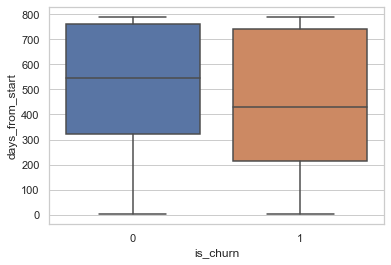

In [20]:
ax = sns.boxplot(x="is_churn", y="days_from_start", data=train_with_features_deduplicated)

### Does churn depend on length of the current subscription?
- This variable needs deeper inversigation.

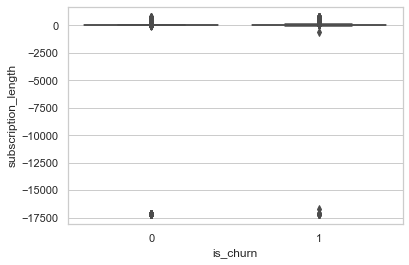

In [26]:
ax = sns.boxplot(x="is_churn", y="subscription_length", 
                 data=train_with_features_deduplicated) #.loc[train_with_features_deduplicated.subscription_length >= 0])

### Does churn depend on number of all transactions that user made?
- Yes, users who churn made a bit less transactions (this is correlated with the first variable)

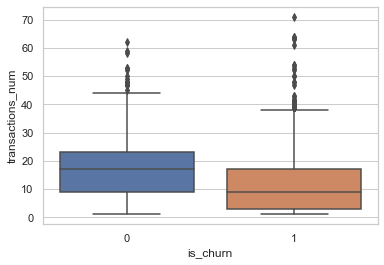

In [28]:
ax = sns.boxplot(x="is_churn", y="transactions_num", data=train_with_features_deduplicated)

### Does churn depend on number of all cancelations that user made?
- Yes, users who churn made more cancelations.

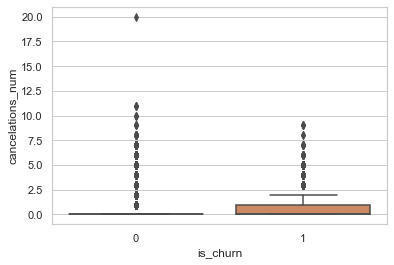

In [29]:
ax = sns.boxplot(x="is_churn", y="cancelations_num", data=train_with_features_deduplicated)

### Does churn depend on the fact if the current subscription is automaticaly renewed?
- Yes, users whose subscripton is automatically renewed churn much less often.

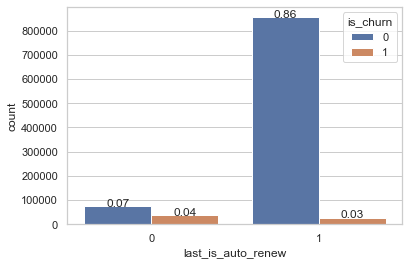

In [44]:
ax = sns.countplot(x="last_is_auto_renew", hue="is_churn", data=train_with_features_deduplicated)
total=train_with_features_deduplicated.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [48]:
print(f"{0.03/0.89: 0.2%} of users whose subscription is automatically renewed churn")
print(f"{0.04/0.11: 0.2%} of users whose subscription is NOT automatically renewed churn")

 3.37% of users whose subscription is automatically renewed churn
 36.36% of users whose subscription is NOT automatically renewed churn


### Modeling with XGboost
Based on tutorial: **"Using XGBoost in Python"**
<br>
https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_campaignid=9942305733&utm_adgroupid=100189364546&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034352&utm_targetid=aud-299261629574:dsa-929501846124&utm_loc_interest_ms=&utm_loc_physical_ms=9060640&gclid=Cj0KCQjw0YD4BRD2ARIsAHwmKVkoOKq4tg0ihd-a5jx70ZIDySVNt1e8bTrBYOOQkPIaLb5aElQY3FgaApotEALw_wcB

In [74]:
from sklearn.model_selection import train_test_split
random.seed(1)
train_set, test_set = train_test_split(all_my_train_features, test_size=0.2)

In [84]:
#XGBoost Model

random.seed(1)
features = [
    "transactions_num", 
    "cancelations_num", 
    "days_from_start", 
    "last_is_auto_renew", 
    "subscription_length",
    "days_from_last_log",
    "last_month_logs_num",
    "total_secs_sum",
    "total_secs_mean",
    "num_unq_sum",
    "num_unq_mean",
    "num_100_sum"
    
# worse result with all of them!
#     "num_25_sum",
#     "num_25_mean",
#     "num_50_sum",
#     "num_50_mean",
#     "num_75_sum",
#     "num_75_mean",
#     "num_985_sum",
#     "num_985_mean",
#     "num_100_mean"
    ]
X_train, y_train = train_set[features], train_set["is_churn"]
X_test, y_test = test_set[features], test_set["is_churn"]

xgb_model = xgb.XGBClassifier(verbosity=1,
                              max_depth=6, 
                              learning_rate=0.4,
                              objective= "binary:logistic",
                              n_jobs=-1).fit(X_train, y_train)

print("Accuracy of XGB classifier on training set: {:.2f}"
       .format(xgb_model.score(X_train, y_train)))
print("Accuracy of XGB classifier on test set: {:.2f}"
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.98
Accuracy of XGB classifier on test set: 0.97


### Features importance
- We need to remember that there are many types of feature importance: 'weight', 'gain', 'cover',
- Default: ‘weight’: the number of times a feature is used to split the data across all trees. It may be lower for features with lower cardinality (like True/False features, so our "last_is_auto_renew"),
- ‘gain’: the average gain across all splits the feature is used in.

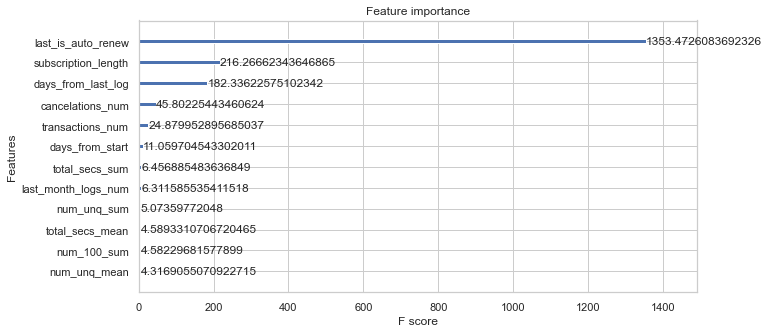

In [85]:
xgb.plot_importance(xgb_model, importance_type="gain")
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [86]:
submission = xgb_model.predict_proba(all_my_test_features[features])

In [87]:
submission_int = xgb_model.predict(all_my_test_features[features])

In [88]:
pd.DataFrame(submission)

,0,1
0,0.993798,0.006202
1,0.997374,0.002626
2,0.998001,0.001999
3,0.996600,0.003400
4,0.890516,0.109484
...,...,...
907466,0.986514,0.013486
907467,0.997308,0.002692
907468,0.545683,0.454317
907469,0.964191,0.035809


In [89]:
final_submission = pd.DataFrame({"msno": test_with_features_deduplicated.msno.reset_index(drop=True), 
                                 "is_churn": pd.DataFrame(submission).loc[:,1]})

In [90]:
final_submission

,msno,is_churn
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.006202
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.002626
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.001999
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0.003400
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.109484
...,...,...
907466,zzxZeMFx2fjfKZigMnJa2w0EmloDbm8+8nTf/o/00GY=,0.013486
907467,zzxi7n5xoTYo9Q3VTygLWvl/rBDcexwaeAry0yK7Q0E=,0.002692
907468,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,0.454317
907469,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,0.035809


In [91]:
final_submission.to_csv("submission_9.csv", index=False)

In [93]:
all_my_train_features[features]

,transactions_num,cancelations_num,days_from_start,last_is_auto_renew,subscription_length,days_from_last_log,last_month_logs_num,total_secs_sum,total_secs_mean,num_unq_sum,num_unq_mean,num_100_sum
0,4,0,105,1,28,1.0,27.0,156533.957,5797.553963,642.0,23.777778,468.0
1,19,0,760,1,47,1.0,28.0,189007.847,6750.280250,722.0,25.785714,762.0
2,26,0,765,1,28,1.0,20.0,123768.839,6188.441950,551.0,27.550000,383.0
3,12,0,351,1,28,1.0,25.0,78863.188,3154.527520,194.0,7.760000,258.0
4,19,0,760,1,51,1.0,18.0,49219.147,2734.397056,261.0,14.500000,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...
992926,26,1,721,1,28,2.0,11.0,115615.729,10510.520818,363.0,33.000000,426.0
992927,4,0,102,1,28,29.0,0.0,0.000,0.000000,0.0,0.000000,0.0
992928,16,1,747,1,52,1.0,17.0,68186.595,4010.976176,281.0,16.529412,222.0
992929,26,1,787,1,1,29.0,0.0,0.000,0.000000,0.0,0.000000,0.0


### Log loss for train and test set

In [101]:
from sklearn.metrics import log_loss
# log_loss(y_true, y_pred)

prediction_test = xgb_model.predict_proba(X_test[features])
prediction_train = xgb_model.predict_proba(X_train[features])
y_pred_test = pd.DataFrame(prediction_test).loc[:,1]
y_pred_train = pd.DataFrame(prediction_train).loc[:,1]
y_true_test = y_test
y_true_train = y_train

print("The lower log loss the better")
print(f"Test set log loss: {log_loss(y_true_test, y_pred_test, normalize=True)}")
print(f"Train set log loss: {log_loss(y_true_train, y_pred_train, normalize=True)}")

The lower log loss the better
Test set log loss: 0.06608614517393854
Train set log loss: 0.05733226934329139


###### Train set log loss < Test set log loss  => Overfitting

#### Ideas to improve:
  - for overfitting: decrease max_depth or change other parameters,
  - create more features,
  - add different periods - maybe there is seasonality?